In [4]:
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer
import matplotlib.pyplot as plt
from wordcloud import WordCloud
from math import log, sqrt
import pandas as pd
import numpy as np
import re
%matplotlib inline

In [5]:
mails = pd.read_table('https://raw.githubusercontent.com/tejank10/Spam-or-Ham/master/spam.csv', encoding = 'latin-1',sep=',')
mails.head()

,v1,v2,Unnamed: 2,Unnamed: 3,Unnamed: 4
0,ham,"Go until jurong point, crazy.. Available only ...",NaN,NaN,NaN
1,ham,Ok lar... Joking wif u oni...,NaN,NaN,NaN
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...,NaN,NaN,NaN
3,ham,U dun say so early hor... U c already then say...,NaN,NaN,NaN
4,ham,"Nah I don't think he goes to usf, he lives aro...",NaN,NaN,NaN


In [6]:
#drop unnamed columnns
mails.drop(['Unnamed: 2', 'Unnamed: 3', 'Unnamed: 4'], axis = 1, inplace = True)
mails.head()

,v1,v2
0,ham,"Go until jurong point, crazy.. Available only ..."
1,ham,Ok lar... Joking wif u oni...
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...
3,ham,U dun say so early hor... U c already then say...
4,ham,"Nah I don't think he goes to usf, he lives aro..."


In [7]:
mails.rename(columns = {'v1': 'labels', 'v2': 'message'}, inplace = True)
mails.head()


,labels,message
0,ham,"Go until jurong point, crazy.. Available only ..."
1,ham,Ok lar... Joking wif u oni...
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...
3,ham,U dun say so early hor... U c already then say...
4,ham,"Nah I don't think he goes to usf, he lives aro..."


In [8]:
mails['labels'].value_counts()

ham     4825
spam     747
Name: labels, dtype: int64

In [9]:
mails['label'] = mails['labels'].map({'ham': 0, 'spam': 1})
mails.head()

,labels,message,label
0,ham,"Go until jurong point, crazy.. Available only ...",0
1,ham,Ok lar... Joking wif u oni...,0
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...,1
3,ham,U dun say so early hor... U c already then say...,0
4,ham,"Nah I don't think he goes to usf, he lives aro...",0


In [10]:
mails.drop(['labels'], axis = 1, inplace = True)
mails.head()

,message,label
0,"Go until jurong point, crazy.. Available only ...",0
1,Ok lar... Joking wif u oni...,0
2,Free entry in 2 a wkly comp to win FA Cup fina...,1
3,U dun say so early hor... U c already then say...,0
4,"Nah I don't think he goes to usf, he lives aro...",0


In [11]:
print(mails.shape[1]) 

2


In [12]:
totalMails = 4825 + 747
trainIndex, testIndex = list(), list()
for i in range(mails.shape[0]):
    if np.random.uniform(0, 1) < 0.75:
        trainIndex += [i]
    else:
        testIndex += [i]
trainData = mails.loc[trainIndex]
testData = mails.loc[testIndex]

In [13]:
trainData.reset_index(inplace = True)
trainData.drop(['index'], axis = 1, inplace = True)
trainData.head()

,message,label
0,"Go until jurong point, crazy.. Available only ...",0
1,"Nah I don't think he goes to usf, he lives aro...",0
2,FreeMsg Hey there darling it's been 3 week's n...,1
3,As per your request 'Melle Melle (Oru Minnamin...,0
4,WINNER!! As a valued network customer you have...,1


In [14]:
testData.reset_index(inplace = True)
testData.drop(['index'], axis = 1, inplace = True)
testData.head()

,message,label
0,Ok lar... Joking wif u oni...,0
1,Free entry in 2 a wkly comp to win FA Cup fina...,1
2,U dun say so early hor... U c already then say...,0
3,Even my brother is not like to speak with me. ...,0
4,I've been searching for the right words to tha...,0


In [15]:
trainData['label'].value_counts()

0    3612
1     547
Name: label, dtype: int64

In [16]:
testData['label'].value_counts()

0    1213
1     200
Name: label, dtype: int64

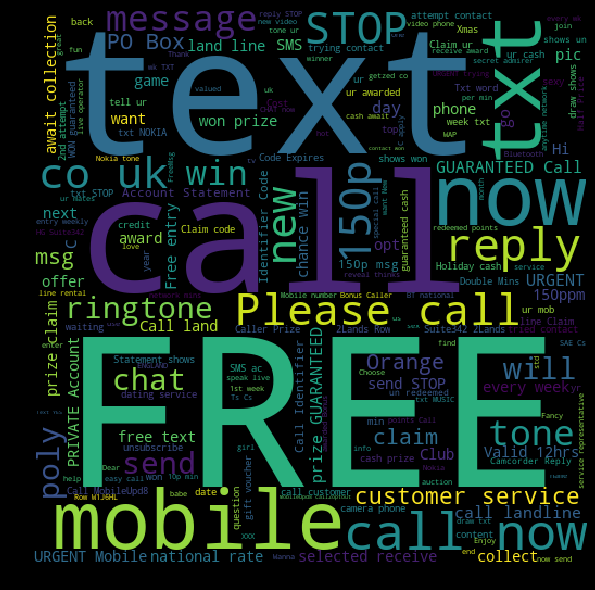

In [17]:
spam_words = ' '.join(list(mails[mails['label'] == 1]['message']))
spam_wc = WordCloud(width = 512,height = 512).generate(spam_words)
plt.figure(figsize = (10, 8), facecolor = 'k')
plt.imshow(spam_wc)
plt.axis('off')
plt.tight_layout(pad = 0)
plt.show()

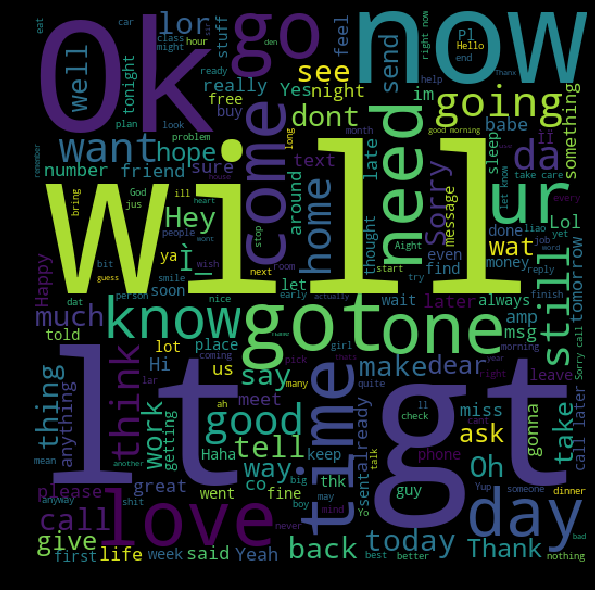

In [18]:
ham_words = ' '.join(list(mails[mails['label'] == 0]['message']))
ham_wc = WordCloud(width = 512,height = 512).generate(ham_words)
plt.figure(figsize = (10, 8), facecolor = 'k')
plt.imshow(ham_wc)
plt.axis('off')
plt.tight_layout(pad = 0)
plt.show()

In [19]:
trainData.head()



,message,label
0,"Go until jurong point, crazy.. Available only ...",0
1,"Nah I don't think he goes to usf, he lives aro...",0
2,FreeMsg Hey there darling it's been 3 week's n...,1
3,As per your request 'Melle Melle (Oru Minnamin...,0
4,WINNER!! As a valued network customer you have...,1


In [20]:
trainData['label'].value_counts()

0    3612
1     547
Name: label, dtype: int64

In [21]:
testData.head()

,message,label
0,Ok lar... Joking wif u oni...,0
1,Free entry in 2 a wkly comp to win FA Cup fina...,1
2,U dun say so early hor... U c already then say...,0
3,Even my brother is not like to speak with me. ...,0
4,I've been searching for the right words to tha...,0


In [22]:
testData['label'].value_counts()


0    1213
1     200
Name: label, dtype: int64

In [23]:
def process_message(message, lower_case = True, stem = True, stop_words = True, gram = 2):
    if lower_case:
        message = message.lower()
    words = word_tokenize(message)
    words = [w for w in words if len(w) > 2]
    if gram > 1:
        w = []
        for i in range(len(words) - gram + 1):
            w += [' '.join(words[i:i + gram])]
        return w
    if stop_words:
        sw = stopwords.words('english')
        words = [word for word in words if word not in sw]
    if stem:
        stemmer = PorterStemmer()
        words = [stemmer.stem(word) for word in words]   
    return words

In [24]:
class SpamClassifier(object):
    def __init__(self, trainData, method = 'tf-idf'):
        self.mails, self.labels = trainData['message'], trainData['label']
        self.method = method

    def train(self):
        self.calc_TF_and_IDF()
        if self.method == 'tf-idf':
            self.calc_TF_IDF()
        else:
            self.calc_prob()

    

    def calc_TF_and_IDF(self):
        noOfMessages = self.mails.shape[0]
        self.spam_mails, self.ham_mails = self.labels.value_counts()[1], self.labels.value_counts()[0]
        self.total_mails = self.spam_mails + self.ham_mails
        self.spam_words = 0
        self.ham_words = 0
        self.tf_spam = dict()
        self.tf_ham = dict()
        self.idf_spam = dict()
        self.idf_ham = dict()
        for i in range(noOfMessages):
            message_processed = process_message(self.mails[i])
            count = list() #To keep track of whether the word has ocured in the message or not.
                           #For IDF
            for word in message_processed:
                if self.labels[i]:
                    self.tf_spam[word] = self.tf_spam.get(word, 0) + 1
                    self.spam_words += 1
                else:
                    self.tf_ham[word] = self.tf_ham.get(word, 0) + 1
                    self.ham_words += 1
                if word not in count:
                    count += [word]
            for word in count:
                if self.labels[i]:
                    self.idf_spam[word] = self.idf_spam.get(word, 0) + 1
                else:
                    self.idf_ham[word] = self.idf_ham.get(word, 0) + 1

    def calc_TF_IDF(self):
        self.prob_spam = dict()
        self.prob_ham = dict()
        self.sum_tf_idf_spam = 0
        self.sum_tf_idf_ham = 0
        for word in self.tf_spam:
            self.prob_spam[word] = (self.tf_spam[word]) * log((self.spam_mails + self.ham_mails) \
                                                          / (self.idf_spam[word] + self.idf_ham.get(word, 0)))
            self.sum_tf_idf_spam += self.prob_spam[word]
        for word in self.tf_spam:
            self.prob_spam[word] = (self.prob_spam[word] + 1) / (self.sum_tf_idf_spam + len(list(self.prob_spam.keys())))
            
        for word in self.tf_ham:
            self.prob_ham[word] = (self.tf_ham[word]) * log((self.spam_mails + self.ham_mails) \
                                                          / (self.idf_spam.get(word, 0) + self.idf_ham[word]))
            self.sum_tf_idf_ham += self.prob_ham[word]
        for word in self.tf_ham:
            self.prob_ham[word] = (self.prob_ham[word] + 1) / (self.sum_tf_idf_ham + len(list(self.prob_ham.keys())))
            
    
        self.prob_spam_mail, self.prob_ham_mail = self.spam_mails / self.total_mails, self.ham_mails / self.total_mails 
                    
    def classify(self, processed_message):
        pSpam, pHam = 0, 0
        for word in processed_message:                
            if word in self.prob_spam:
                pSpam += log(self.prob_spam[word])
            else:
                if self.method == 'tf-idf':
                    pSpam -= log(self.sum_tf_idf_spam + len(list(self.prob_spam.keys())))
                else:
                    pSpam -= log(self.spam_words + len(list(self.prob_spam.keys())))
            if word in self.prob_ham:
                pHam += log(self.prob_ham[word])
            else:
                if self.method == 'tf-idf':
                    pHam -= log(self.sum_tf_idf_ham + len(list(self.prob_ham.keys()))) 
                else:
                    pHam -= log(self.ham_words + len(list(self.prob_ham.keys())))
            pSpam += log(self.prob_spam_mail)
            pHam += log(self.prob_ham_mail)
        return pSpam >= pHam
    
    def predict(self, testData):
        result = dict()
        for (i, message) in enumerate(testData):
            processed_message = process_message(message)
            result[i] = int(self.classify(processed_message))
        return result

In [25]:
def metrics(labels, predictions):
    true_pos, true_neg, false_pos, false_neg = 0, 0, 0, 0
    for i in range(len(labels)):
        true_pos += int(labels[i] == 1 and predictions[i] == 1)
        true_neg += int(labels[i] == 0 and predictions[i] == 0)
        false_pos += int(labels[i] == 0 and predictions[i] == 1)
        false_neg += int(labels[i] == 1 and predictions[i] == 0)
    precision = true_pos / (true_pos + false_pos)
    recall = true_pos / (true_pos + false_neg)
    Fscore = 2 * precision * recall / (precision + recall)
    accuracy = (true_pos + true_neg) / (true_pos + true_neg + false_pos + false_neg)

    print("Precision: ", precision)
    print("Recall: ", recall)
    print("F-score: ", Fscore)
    print("Accuracy: ", accuracy)

In [26]:
sc_tf_idf = SpamClassifier(trainData, 'tf-idf')
sc_tf_idf.train()
preds_tf_idf = sc_tf_idf.predict(testData['message'])
metrics(testData['label'], preds_tf_idf)

Precision:  0.9054054054054054
Recall:  0.67
F-score:  0.7701149425287356
Accuracy:  0.943382873319179


In [28]:
pm = process_message('I cant pick the phone right now. Pls send a message')
sc_tf_idf.classify(pm)

False

In [29]:
pm = process_message('Congratulations ur awarded $500 ')
sc_tf_idf.classify(pm)

True